# Running ML(Logistic Regression) Indicator Model Jupyter Notebook 
The purpose of this note book is to Use PyCaret to test models and Run a Logistic Regression MODEL:
1. Import data from Yahoo Finance
2. Clean and Format Data
3. Create Indicator shift parameters
4. Run PyCaret ML analysis
5. Validate Results by Running Logistic Regression Model 






In [ ]:
#pip install yfinance


# A. Import Python Libraries

In [332]:
# Initial imports
import os
import csv
import requests
import pandas as pd
#from MCForecastTools import MCSimulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
from pathlib import Path
import pycaret
import datetime as dt
from pycaret.classification import *

#Subsequent imports
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

# Enable the Matplotlib property to allow diagrams to display in Jupyter Notebook
%matplotlib inline

# B. Import Data - Security/Stock Prices

## Yahoo Finance Data


In [333]:
# List the ticker symbols for the stocks of interest
lst=['BMO.TO', 'BNS.TO', 'CM.TO', 'NA.TO','RY.TO', 'TD.TO', 'ZEB.TO','ZWB.TO', 'XGB.TO', 'CL' ]

# Determine the start and end dates
start_date = '2014-01-01'
end_date = '2022-11-28'

# Create empty dataframe to hold stock data
dfAllStocks_Yahoo=pd.DataFrame()

# Gathers stock data from listed tickers and combines them into a dataframe
for ticker in lst:
    # Create data frame from API in loop 
    df= yf.download(ticker, start= start_date, end= end_date,index_col='Date', parse_dates=True, infer_datetime_format=True)
    # Remove to '.TO' suffix from Canadian stocks
    tic= ticker.replace('.TO','')
    df['Ticker']=tic
    # Drop unwanted coloumns - Keep Adjusted Close
    df.drop(columns= ["Open", "High", "Low", "Volume", "Adj Close", "Ticker"], inplace= True)
    # Combine individual stocks into a single data frame
    dfAllStocks_Yahoo=pd.concat([dfAllStocks_Yahoo, df], axis= 1)

# Rename the coloumns to the ticker symbols in the list
dfAllStocks_Yahoo.columns = lst
dfAllStocks_Yahoo.index.name = 'Date'

# Drop the N/As
dfAllStocks_Yahoo = dfAllStocks_Yahoo.dropna()

# Display the data
display(dfAllStocks_Yahoo)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL
Date,,,,,,,,,,
2014-01-02,70.730003,66.010002,45.035000,44.154999,71.589996,49.435001,21.240000,16.040001,20.709999,64.300003
2014-01-03,71.040001,65.459999,44.730000,44.125000,71.389999,49.424999,21.230000,16.030001,20.709999,64.180000
2014-01-06,70.839996,64.739998,44.395000,43.630001,70.699997,48.994999,21.049999,15.910000,20.780001,64.139999
2014-01-07,70.940002,64.480003,44.215000,43.514999,70.970001,48.955002,21.030001,15.910000,20.840000,64.199997
2014-01-08,71.000000,64.400002,44.009998,43.540001,71.000000,49.040001,21.030001,15.900000,20.770000,63.540001
...,...,...,...,...,...,...,...,...,...,...
2022-11-18,132.270004,69.040001,63.560001,97.389999,132.699997,89.419998,35.919998,19.360001,19.000000,76.459999
2022-11-21,131.089996,70.190002,63.970001,97.389999,132.949997,89.760002,36.029999,19.430000,19.020000,76.919998
2022-11-22,131.990005,70.510002,64.290001,98.540001,134.830002,90.739998,36.349998,19.580000,19.129999,76.370003


In [334]:
#Slicing Data for Train and Test Model
df_model_1 = dfAllStocks_Yahoo.loc['2014-01-02':'2018-12-31':1]
display(df_model_1)



,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL
Date,,,,,,,,,,
2014-01-02,70.730003,66.010002,45.035000,44.154999,71.589996,49.435001,21.240000,16.040001,20.709999,64.300003
2014-01-03,71.040001,65.459999,44.730000,44.125000,71.389999,49.424999,21.230000,16.030001,20.709999,64.180000
2014-01-06,70.839996,64.739998,44.395000,43.630001,70.699997,48.994999,21.049999,15.910000,20.780001,64.139999
2014-01-07,70.940002,64.480003,44.215000,43.514999,70.970001,48.955002,21.030001,15.910000,20.840000,64.199997
2014-01-08,71.000000,64.400002,44.009998,43.540001,71.000000,49.040001,21.030001,15.900000,20.770000,63.540001
...,...,...,...,...,...,...,...,...,...,...
2018-12-21,87.180000,67.089996,50.654999,55.400002,90.949997,66.150002,25.700001,16.750000,21.250000,59.910000
2018-12-24,86.320000,66.839996,50.400002,54.970001,90.209999,65.610001,25.500000,16.639999,21.299999,58.040001
2018-12-27,88.620003,68.260002,50.529999,55.619999,92.709999,67.510002,25.969999,16.889999,21.330000,59.689999


# C. EDA - Exploratory Data Analysis



## C.1. Plot BNS Daily Stock Price

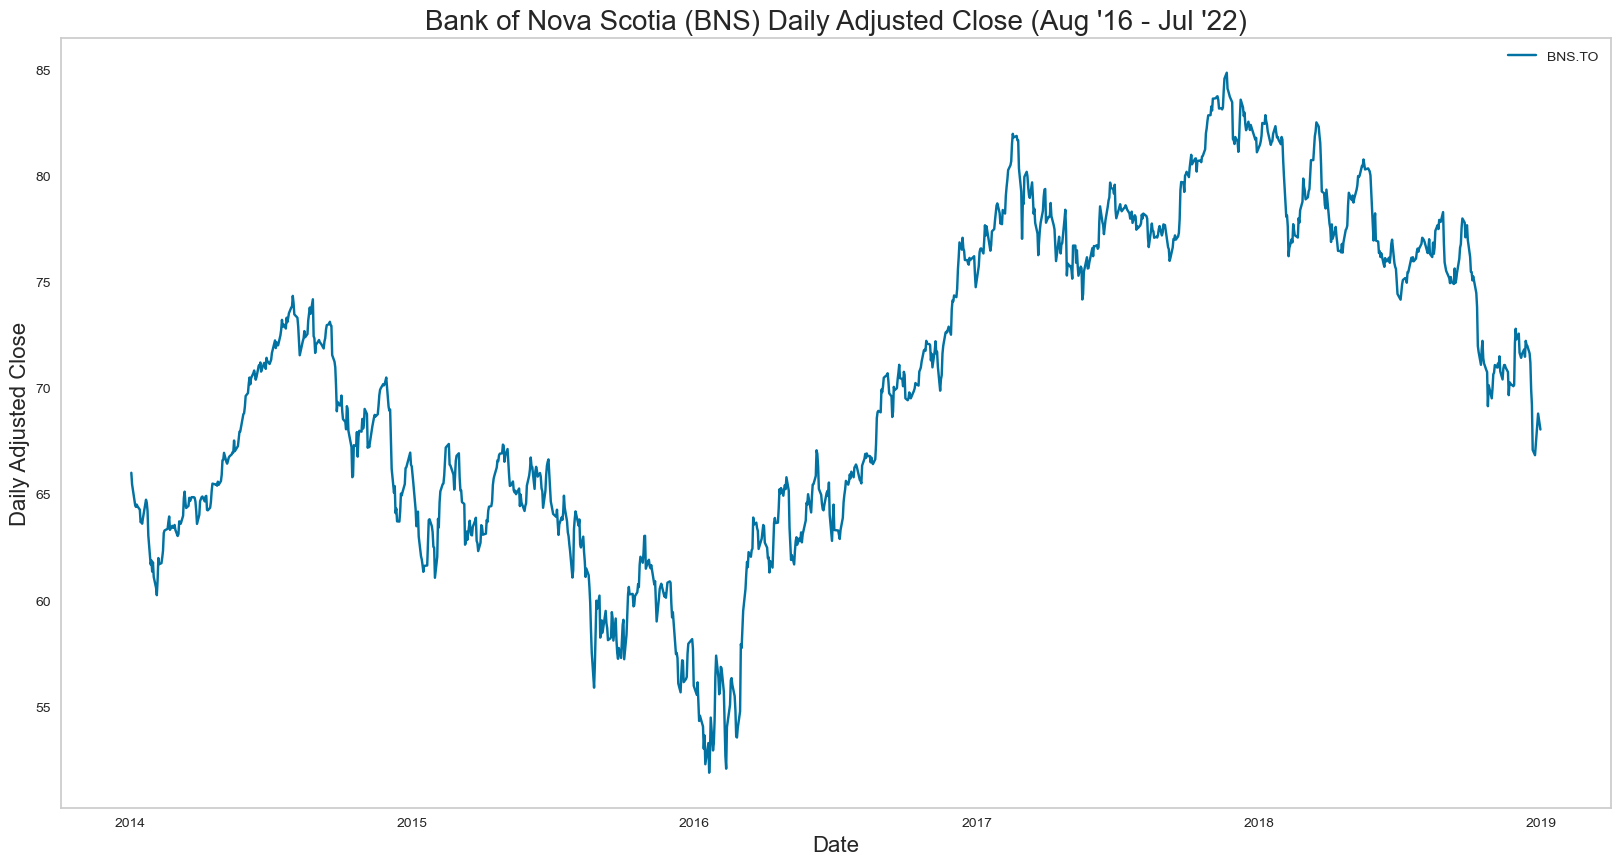

In [335]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

plt.plot(df_model_1[['BNS.TO']])
plt.title("Bank of Nova Scotia (BNS) Daily Adjusted Close (Aug '16 - Jul '22)", fontsize = 20)
plt.ylabel("Daily Adjusted Close", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(df_model_1[['BNS.TO']].columns)
plt.grid()

plt.show()


## C.2. Summary Statistics

In [336]:
# Sumary Statistics of all Socks
df_model_1.describe()


,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL
count,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000
mean,86.661111,70.192117,51.935328,51.474225,85.501590,61.274302,24.989805,17.436683,21.744290,68.420284
std,11.011608,7.512823,4.880482,7.819683,11.134626,8.909951,3.092849,1.369107,0.542405,3.904232
min,66.180000,51.869999,41.665001,35.830002,65.000000,47.619999,19.260000,14.020000,20.709999,57.880001
25%,76.879997,64.260002,47.994999,45.150002,75.949997,54.130001,22.299999,16.299999,21.270000,65.550003
50%,83.830002,70.199997,50.875000,49.139999,80.980003,57.200001,23.990000,17.250000,21.650000,68.150002
75%,97.680000,76.959999,56.150002,58.380001,96.220001,69.500000,27.950001,18.650000,22.150000,71.599998
max,108.320000,84.870003,62.294998,65.629997,108.050003,79.730003,30.600000,19.940001,23.020000,77.500000


## C.3. Daily Returns

In [337]:
# Calculate Daily Returns
# Drop nulls
df_model_1 = df_model_1.pct_change().dropna().copy()

# Display sample data
df_model_1

,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL
Date,,,,,,,,,,
2014-01-03,0.004383,-0.008332,-0.006773,-0.000679,-0.002794,-0.000202,-0.000471,-0.000623,0.000000,-0.001866
2014-01-06,-0.002815,-0.010999,-0.007489,-0.011218,-0.009665,-0.008700,-0.008479,-0.007486,0.003380,-0.000623
2014-01-07,0.001412,-0.004016,-0.004055,-0.002636,0.003819,-0.000816,-0.000950,0.000000,0.002887,0.000935
2014-01-08,0.000846,-0.001241,-0.004636,0.000575,0.000423,0.001736,0.000000,-0.000629,-0.003359,-0.010280
2014-01-09,0.002958,0.001708,0.006930,0.009761,0.001690,-0.000204,0.002853,0.003145,0.003370,0.023292
...,...,...,...,...,...,...,...,...,...,...
2018-12-21,-0.014804,-0.030772,-0.019359,-0.020163,-0.013664,-0.015479,-0.017959,-0.018746,-0.002347,-0.017547
2018-12-24,-0.009865,-0.003726,-0.005034,-0.007762,-0.008136,-0.008163,-0.007782,-0.006567,0.002353,-0.031213
2018-12-27,0.026645,0.021245,0.002579,0.011825,0.027713,0.028959,0.018431,0.015024,0.001408,0.028429


In [338]:
#all_stocks_returns_df['Delta']=  all_stocks_df[['BNS.TO']].diff().dropna().copy()
#all_stocks_returns_df


In [339]:
# Sumary Statistics of all Socks
df_model_1.describe()


,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000
mean,0.000223,0.000066,0.000135,0.000245,0.000253,0.000293,0.000199,0.000073,0.000025,-0.000006
std,0.008282,0.009095,0.008534,0.010140,0.008552,0.008423,0.007575,0.006938,0.002719,0.010629
min,-0.043290,-0.038361,-0.035512,-0.052595,-0.039009,-0.055524,-0.029382,-0.028649,-0.010412,-0.066437
25%,-0.003331,-0.004246,-0.003750,-0.004124,-0.003818,-0.003856,-0.003523,-0.003094,-0.001421,-0.004849
50%,0.000693,0.000386,0.000690,0.000546,0.000635,0.000713,0.000840,0.000604,0.000000,0.000134
75%,0.004567,0.005055,0.004593,0.005338,0.004963,0.004661,0.004222,0.003647,0.001824,0.005498
max,0.047626,0.057889,0.058576,0.052935,0.045846,0.036516,0.037245,0.038515,0.011385,0.060043


### C.2.i. Daily Returns - Percent Change

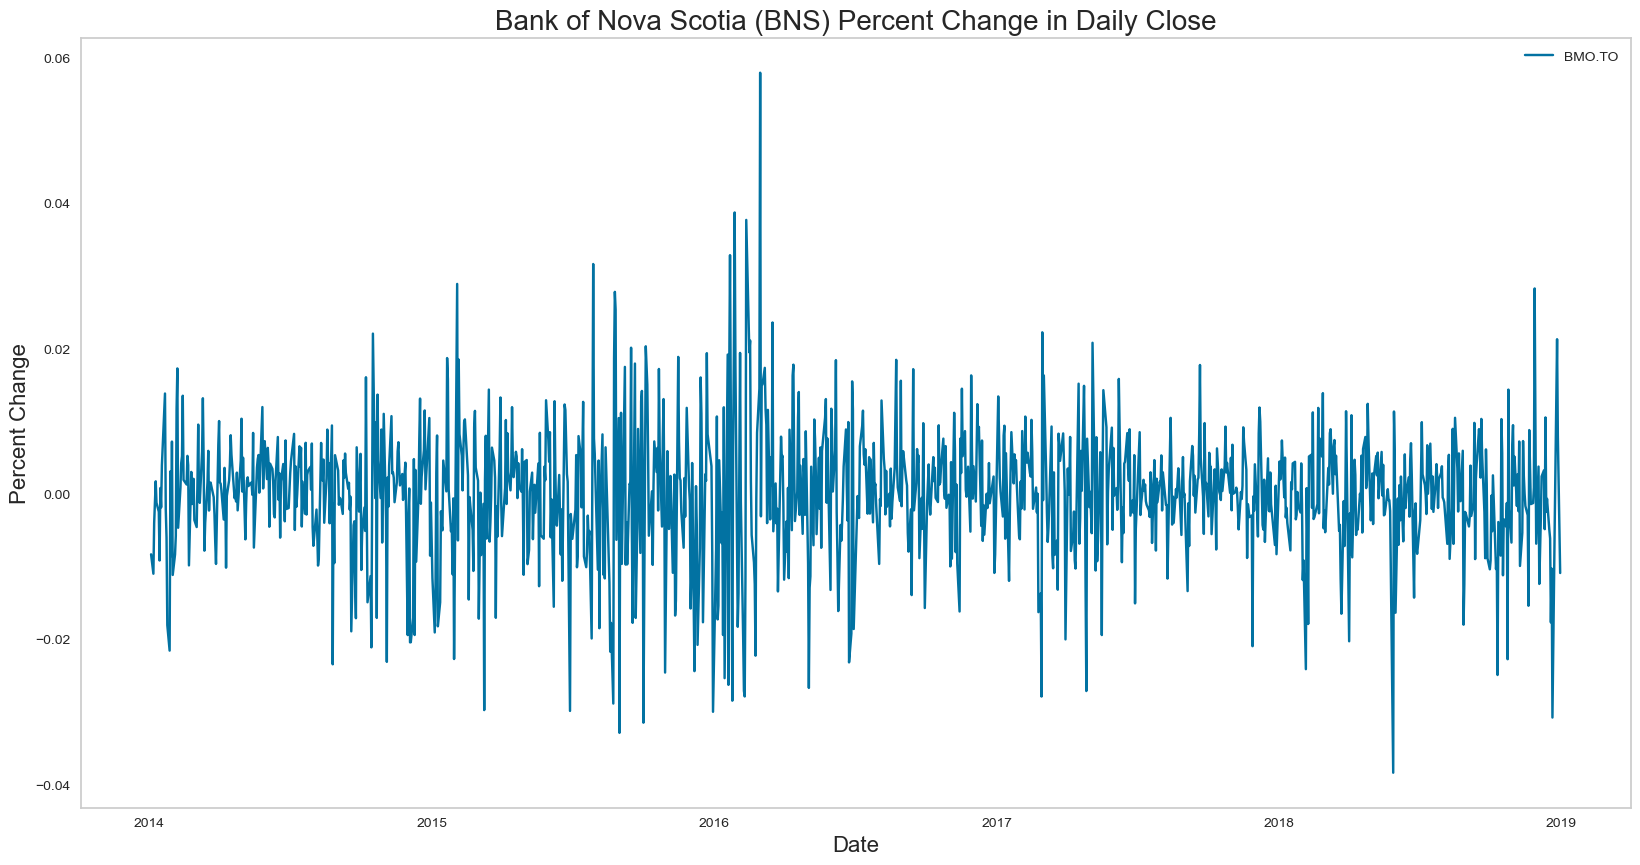

In [340]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

plt.plot(df_model_1[['BNS.TO']])
plt.title("Bank of Nova Scotia (BNS) Percent Change in Daily Close", fontsize = 20)
plt.ylabel("Percent Change", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(df_model_1.columns)
plt.grid()

plt.show()


### C.2.ii. Box Plot - Daily Returns

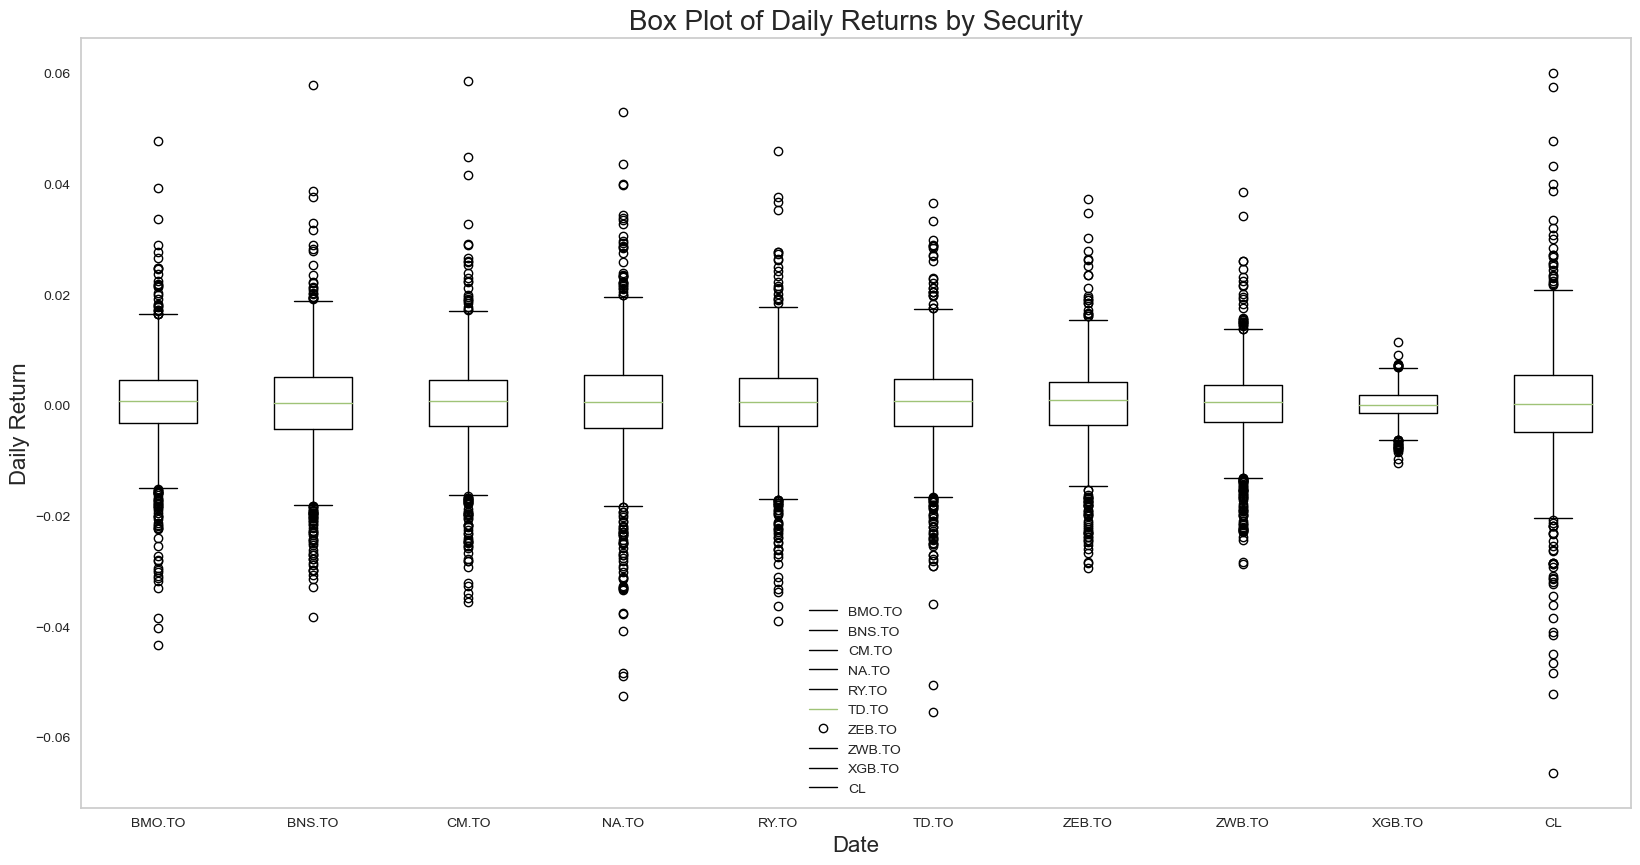

In [341]:
# Box plot to visually show risk
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

plt.boxplot(df_model_1)
plt.title("Box Plot of Daily Returns by Security", fontsize = 20)
plt.ylabel("Daily Return", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(df_model_1.columns)
ax.set_xticklabels(df_model_1.columns)
plt.grid()

plt.show()


### C.2.iii. Calculate and plot rolling Standard Deviation with 21-day/4-week window


In [342]:
# Calculate rolling standard deviation
rolling_std_21 = df_model_1.rolling(21).std().dropna().copy().sort_index()

# Display sample data
rolling_std_21.head()


,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL
Date,,,,,,,,,,
2014-02-03,0.007799,0.008158,0.005969,0.007919,0.009629,0.005465,0.006706,0.005981,0.002541,0.009765
2014-02-04,0.007658,0.008110,0.005892,0.008372,0.009676,0.005529,0.006692,0.005981,0.002678,0.009853
2014-02-05,0.008154,0.008609,0.006612,0.008195,0.010209,0.005479,0.007115,0.006421,0.002674,0.009881
2014-02-06,0.008798,0.009650,0.007053,0.008525,0.010618,0.006641,0.007968,0.007227,0.002847,0.009930
2014-02-07,0.008864,0.009668,0.006989,0.008525,0.010628,0.006626,0.007966,0.007235,0.002749,0.009883


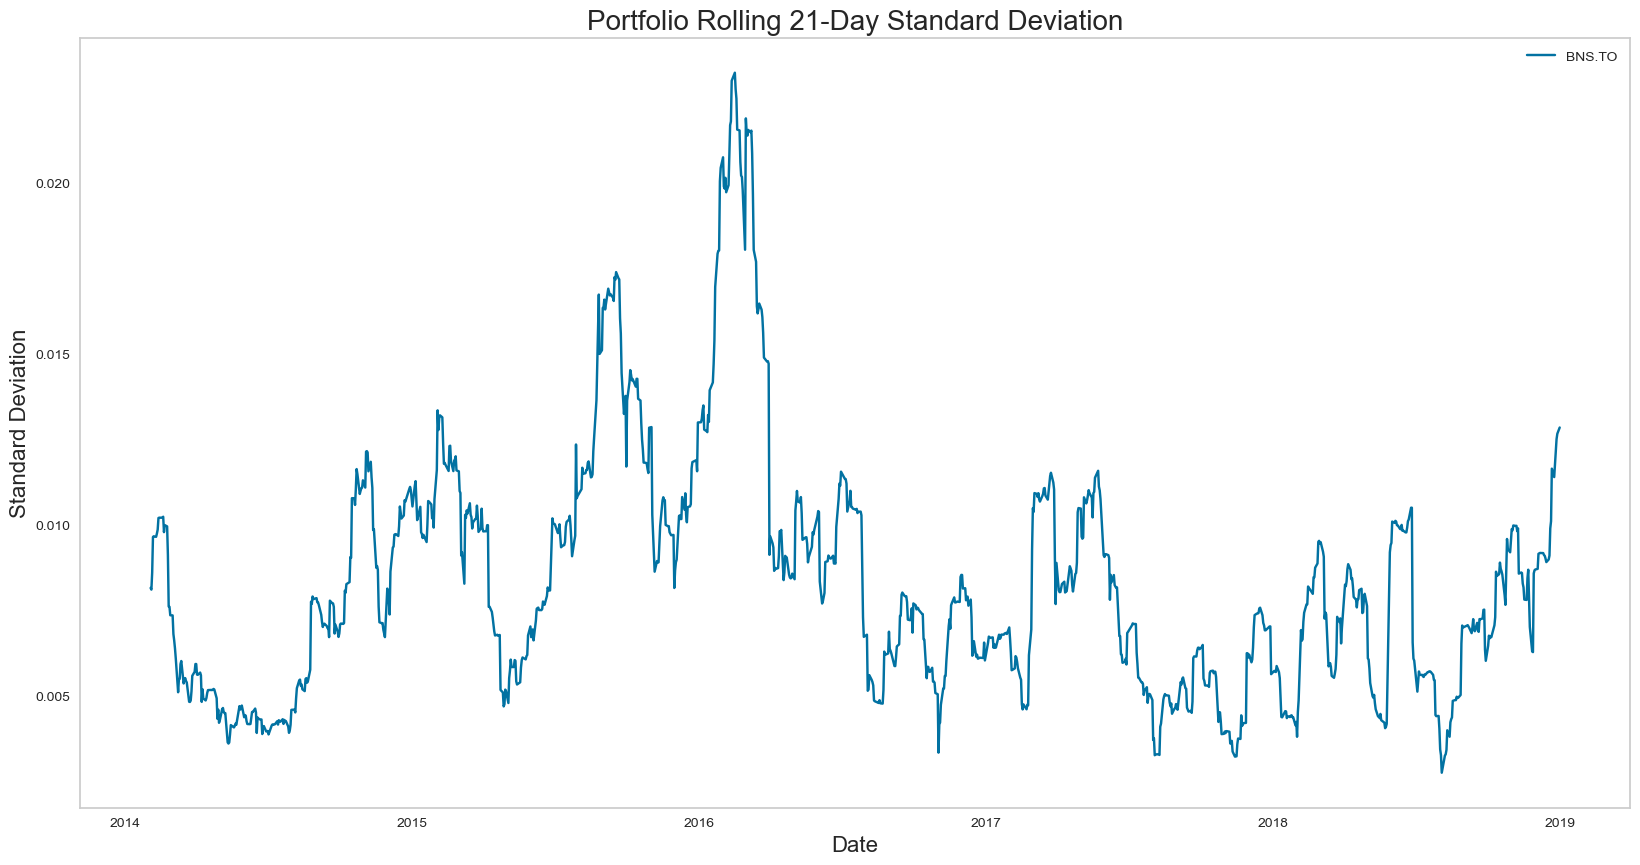

In [343]:
# Plot rolling standard deviation
fig = plt.figure(figsize=(20,10))

plt.plot(rolling_std_21[['BNS.TO']])
plt.title("Portfolio Rolling 21-Day Standard Deviation", fontsize = 20)
plt.ylabel("Standard Deviation", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(rolling_std_21[['BNS.TO']].columns)
plt.grid()

plt.show()


### C.2.iv. Calculate and plot the correlation

In [344]:
# Calculate and plot the correlation
correlation = df_model_1.corr()

# Display Correlation Matrix
correlation


,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL
BMO.TO,1.000000,0.699664,0.690303,0.667621,0.754663,0.719648,0.848299,0.827704,-0.262092,0.266112
BNS.TO,0.699664,1.000000,0.697670,0.684802,0.750534,0.723541,0.870057,0.853723,-0.237065,0.269908
CM.TO,0.690303,0.697670,1.000000,0.634971,0.717698,0.692846,0.836706,0.822828,-0.260055,0.273774
NA.TO,0.667621,0.684802,0.634971,1.000000,0.687669,0.634375,0.827609,0.804243,-0.244572,0.245995
RY.TO,0.754663,0.750534,0.717698,0.687669,1.000000,0.753269,0.885683,0.866926,-0.250691,0.255960
TD.TO,0.719648,0.723541,0.692846,0.634375,0.753269,1.000000,0.851887,0.835657,-0.259762,0.264579
ZEB.TO,0.848299,0.870057,0.836706,0.827609,0.885683,0.851887,1.000000,0.980822,-0.300624,0.302768
ZWB.TO,0.827704,0.853723,0.822828,0.804243,0.866926,0.835657,0.980822,1.000000,-0.302105,0.304529
XGB.TO,-0.262092,-0.237065,-0.260055,-0.244572,-0.250691,-0.259762,-0.300624,-0.302105,1.000000,-0.059974
CL,0.266112,0.269908,0.273774,0.245995,0.255960,0.264579,0.302768,0.304529,-0.059974,1.000000


<AxesSubplot:>

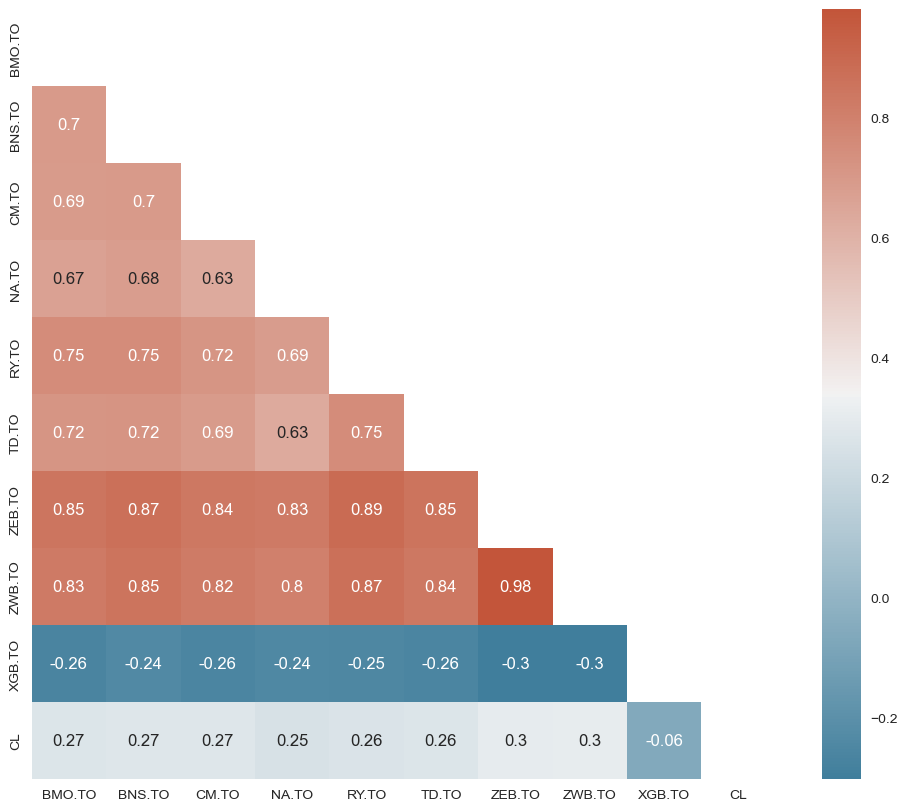

In [345]:
# Correlation between different variables
corr = df_model_1.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

# Reference: https://vitalflux.com/correlation-heatmap-with-seaborn-pandas/


### C.2.v. Calculate and Plot the 60-day Correlation between stocks and BNS 


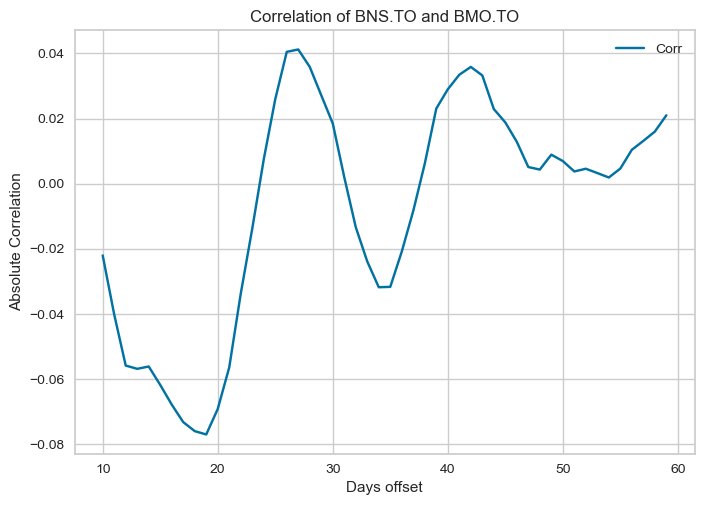

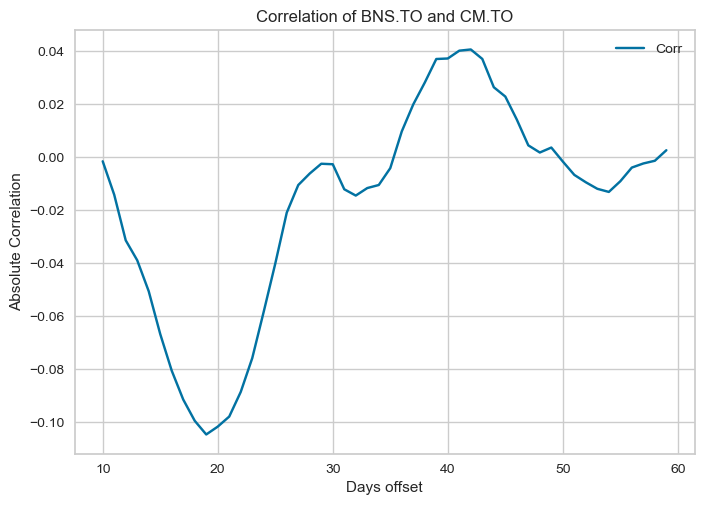

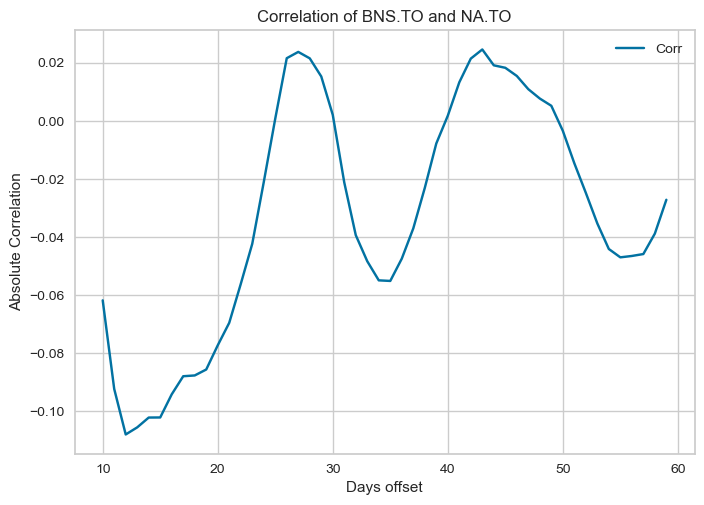

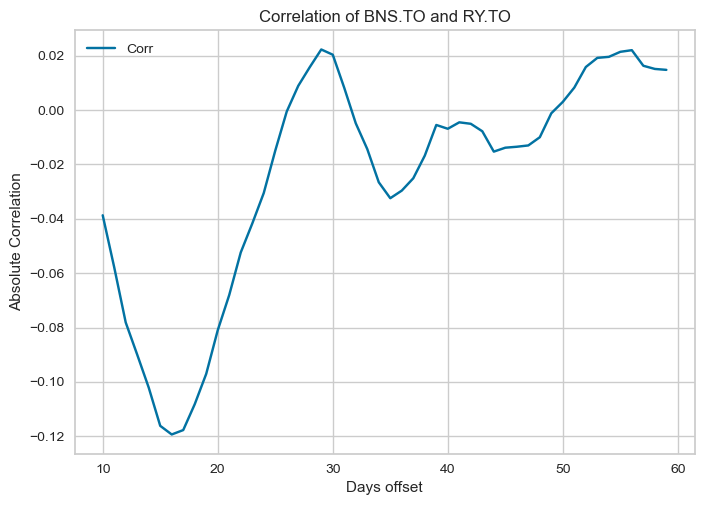

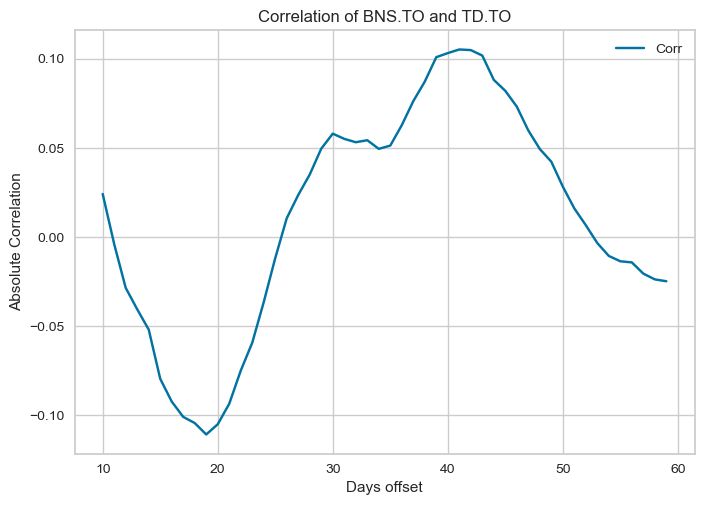

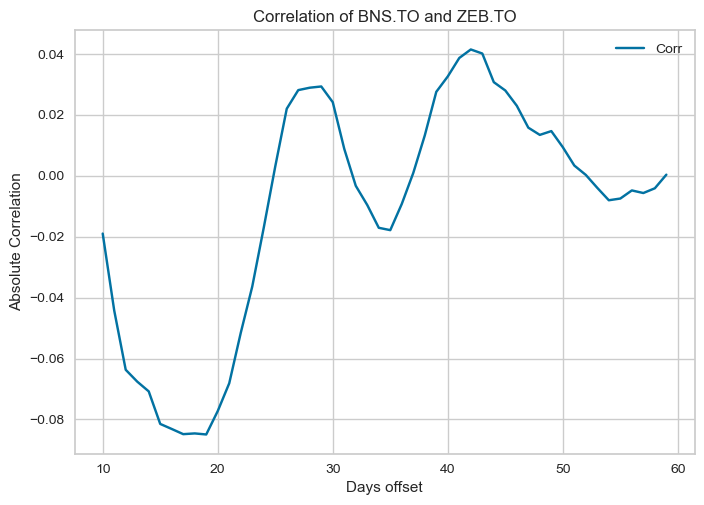

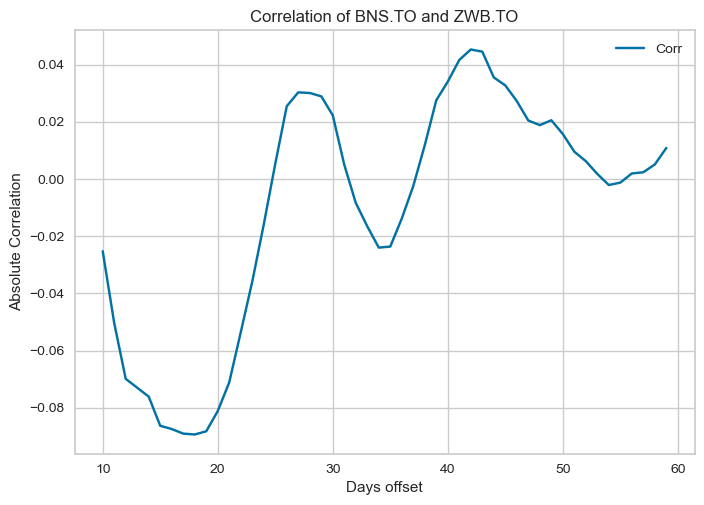

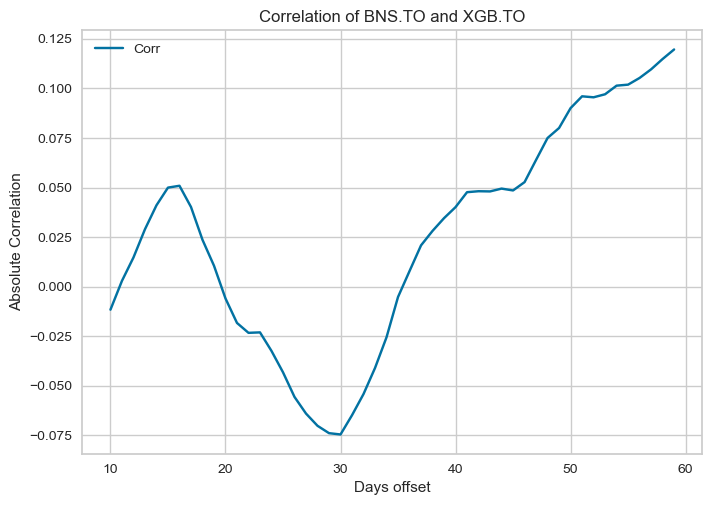

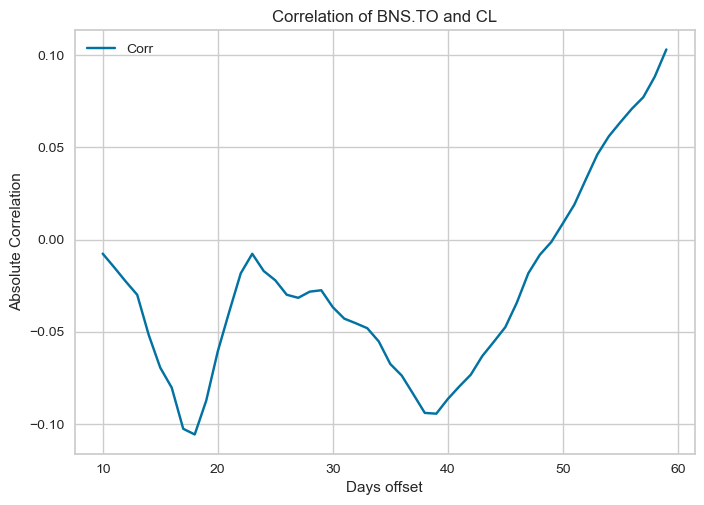

In [346]:
# Loop through all securities as a leading indicator:
index_count = 0
max_range = 60
df_correlation = pd.DataFrame(columns = ['p', 'Leader', 'Target', 'Corr', 'AbsCorr'] )
lst = dfAllStocks_Yahoo.columns.to_list()
lst.remove('BNS.TO')
target = ['BNS.TO']

# Compare each stock to BNS and determine the correlation over time
for leader in lst:
    # Create and empty DataFrame for closing prices
    df_closing_prices = pd.DataFrame()
        
    # Fetch the closing prices of Stock being lead
    df_closing_prices[leader] = dfAllStocks_Yahoo[leader]
    df_closing_prices[target] = dfAllStocks_Yahoo[target]
        
    # Drop columns not required
    df_closing_prices=df_closing_prices.dropna()

    # Loop through various Leading Indicator Scenarios:
    x=10
    for p in range(x, max_range):
        dfopt=df_closing_prices
        dfopt['Target_Change']=dfopt[target].pct_change(x).shift(-p)
        dfopt['Leader_Change']=dfopt[leader].pct_change(p)
        dfopt=dfopt[['Target_Change','Leader_Change']]
        dfcorr = dfopt.corr() 
        dfopt=dfopt.dropna()
        dfopt['RtnQuantile']=pd.qcut(dfopt['Target_Change'], 5, labels = False)
        dfPlot=dfopt.groupby('RtnQuantile')[['Leader_Change']].mean()
        
        # Put correlation into a dataframe            
        df_temp = pd.DataFrame({"p":p, "Leader":leader, "Target":target, "Corr":dfcorr.iloc[0][1], "AbsCorr": abs(dfcorr.iloc[0][1])}, index = [index_count])
        df_correlation = pd.concat([df_correlation, df_temp], axis = "rows")
        index_count += 1
        
    # Plot the correlation between BNS and the leader as a function of the number of days offset
    df_leader = df_correlation.loc[df_correlation['Leader'] == leader]

    df_leader.plot(x = 'p', y = 'Corr', title= f'Correlation of BNS.TO and {leader}', xlabel= 'Days offset', ylabel='Absolute Correlation')
    
    #display(dfPlot.hvplot.bar())
    #display(dfopt.hvplot.scatter(y='Target_Change',x='Leader_Change'))
            
    #del(dfopt)
    #del(dfPlot)
  

In [347]:
# Correlation loop results
df_correlation.drop(df_correlation[(df_correlation['Leader'] == 'BNS.TO')].index, inplace=True)
display(df_correlation)


,p,Leader,Target,Corr,AbsCorr
0,10,BMO.TO,BNS.TO,-0.022032,0.022032
1,11,BMO.TO,BNS.TO,-0.040156,0.040156
2,12,BMO.TO,BNS.TO,-0.055826,0.055826
3,13,BMO.TO,BNS.TO,-0.056835,0.056835
4,14,BMO.TO,BNS.TO,-0.056117,0.056117
...,...,...,...,...,...
445,55,CL,BNS.TO,0.063661,0.063661
446,56,CL,BNS.TO,0.070973,0.070973
447,57,CL,BNS.TO,0.077273,0.077273
448,58,CL,BNS.TO,0.088478,0.088478


In [348]:
# Sorting correlation to identify highest Absolute Correlations
df_correlation.iloc[(-df_correlation['Corr'].abs()).argsort()]


,p,Leader,Target,Corr,AbsCorr
399,59,XGB.TO,BNS.TO,0.119657,0.119657
156,16,RY.TO,BNS.TO,-0.119369,0.119369
157,17,RY.TO,BNS.TO,-0.117750,0.117750
155,15,RY.TO,BNS.TO,-0.116187,0.116187
398,58,XGB.TO,BNS.TO,0.114845,0.114845
...,...,...,...,...,...
277,37,ZEB.TO,BNS.TO,0.000929,0.000929
115,25,NA.TO,BNS.TO,0.000780,0.000780
166,26,RY.TO,BNS.TO,-0.000494,0.000494
299,59,ZEB.TO,BNS.TO,0.000351,0.000351


In [349]:

Highest_Corr_Vaiable =df_correlation.sort_values(by=['AbsCorr'],ascending=[False])
Highest_Corr_Vaiable.head(30)


,p,Leader,Target,Corr,AbsCorr
399,59,XGB.TO,BNS.TO,0.119657,0.119657
156,16,RY.TO,BNS.TO,-0.119369,0.119369
157,17,RY.TO,BNS.TO,-0.117750,0.117750
155,15,RY.TO,BNS.TO,-0.116187,0.116187
398,58,XGB.TO,BNS.TO,0.114845,0.114845
209,19,TD.TO,BNS.TO,-0.110740,0.110740
397,57,XGB.TO,BNS.TO,0.109635,0.109635
158,18,RY.TO,BNS.TO,-0.108229,0.108229
102,12,NA.TO,BNS.TO,-0.107948,0.107948
408,18,CL,BNS.TO,-0.105701,0.105701


## C.4. Cumulative Daily Returns

In [350]:
# Calculate cumulative returns of all portfolios
all_stocks_cumulative_returns = (1 + df_model_1).cumprod().copy()

# Display sample data
all_stocks_cumulative_returns     


,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL
Date,,,,,,,,,,
2014-01-03,1.004383,0.991668,0.993227,0.999321,0.997206,0.999798,0.999529,0.999377,1.000000,0.998134
2014-01-06,1.001555,0.980760,0.985789,0.988110,0.987568,0.991099,0.991055,0.991895,1.003380,0.997512
2014-01-07,1.002969,0.976822,0.981792,0.985506,0.991340,0.990290,0.990113,0.991895,1.006277,0.998445
2014-01-08,1.003817,0.975610,0.977240,0.986072,0.991759,0.992010,0.990113,0.991272,1.002897,0.988180
2014-01-09,1.006786,0.977276,0.984012,0.995697,0.993435,0.991807,0.992938,0.994389,1.006277,1.011197
...,...,...,...,...,...,...,...,...,...,...
2018-12-21,1.232575,1.016361,1.124792,1.254671,1.270429,1.338121,1.209981,1.044264,1.026074,0.931726
2018-12-24,1.220416,1.012574,1.119130,1.244933,1.260092,1.327197,1.200565,1.037406,1.028489,0.902644
2018-12-27,1.252934,1.034086,1.122016,1.259654,1.295013,1.365632,1.222693,1.052992,1.029937,0.928305


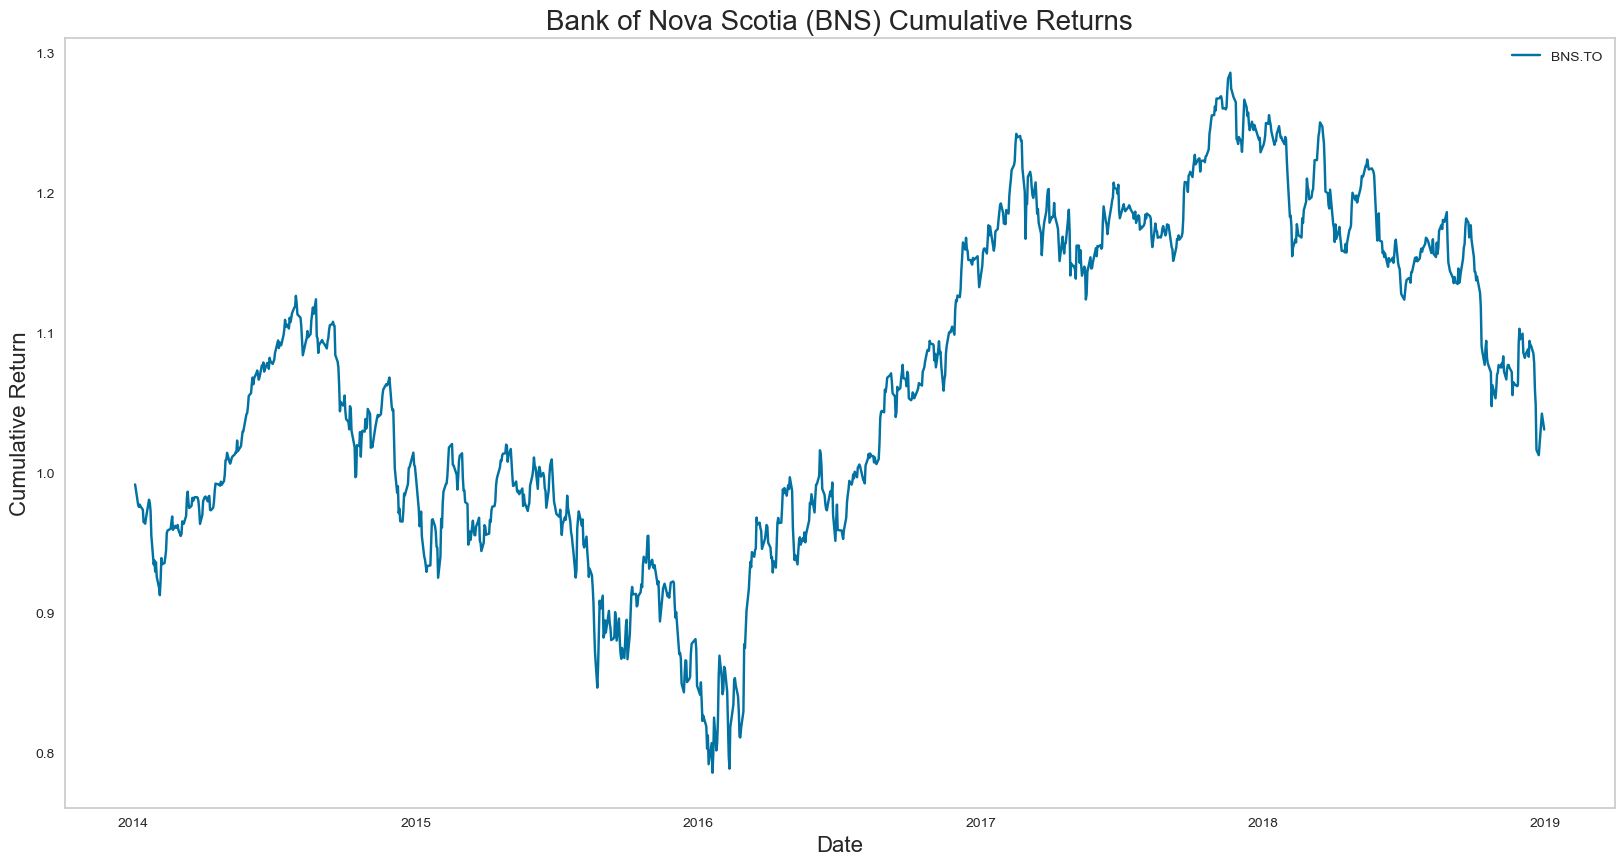

In [351]:
# Plot cumulative returns
fig = plt.figure(figsize=(20,10))

plt.plot(all_stocks_cumulative_returns[['BNS.TO']])
plt.title("Bank of Nova Scotia (BNS) Cumulative Returns", fontsize = 20)
plt.ylabel("Cumulative Return", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(all_stocks_cumulative_returns[['BNS.TO']].columns)
plt.grid()

plt.show()

# Prepare Data for Analysis

## 3. Analysis Routine - Executing shifts and %Changes across Data Frame
1. Create the y variable of 0's and 1's 
2. Identify shifts and % Changes with highest correlation over df. (List provided by Team Members)
    CM = shift (30); %(26)<br>
    CM = shift (30); %(5)<br>
    NA = shift (27); %(12)<br>
    TD = shift (41); %(39)<br>
   BMO = shift (35); %(5)<br>
   ZWB = shift (37); %(15)<br>
   ZEB = shift (25); %(21)<br>
    RY = shift (37); %(15)<br>
    CL = shift (29); %(23)<br>
    CL = shift (38); %(6)<br>
    CL = shift (31); %(21)<br>
    CL = shift (35); %(17)<br>
    



In [352]:
df_model_1['y']=np.where(df_model_1['BNS.TO']>=0,1,0)

            

In [353]:
df_model_2=pd.DataFrame()


In [354]:
df_model_2['y']= df_model_1['BNS.TO'].pct_change(7)
df_model_2['CM_30']= df_model_1['CM.TO'].shift(30).pct_change(26)
df_model_2['CM_30']= df_model_1['CM.TO'].shift(30).pct_change(5)
df_model_2['NA_27']=df_model_1['NA.TO'].shift(27).pct_change(12)
df_model_2['TD_41']=df_model_1['TD.TO'].shift(41).pct_change(39)
df_model_2['BMO_35']=df_model_1['BMO.TO'].shift(35).pct_change(5)
df_model_2['ZWB_37']=df_model_1['ZWB.TO'].shift(37).pct_change(15)
df_model_2['ZEB_30']=df_model_1['ZEB.TO'].shift(30).pct_change(16)
df_model_2['ZEB_25']=df_model_1['ZEB.TO'].shift(25).pct_change(21)
df_model_2['RY_37']=df_model_1['RY.TO'].shift(37).pct_change(15)
df_model_2['CL_29']=df_model_1['CL'].shift(29).pct_change(23)
df_model_2['CL_38']=df_model_1['CL'].shift(38).pct_change(6)
df_model_2['CL_31']=df_model_1['CL'].shift(31).pct_change(21)
df_model_2['CL_35']=df_model_1['CL'].shift(35).pct_change(17)




In [355]:
df_model_2['y']=np.where(df_model_2['y']>=0,1,0)


In [356]:

display(df_model_2.head(5))


,y,CM_30,NA_27,TD_41,BMO_35,ZWB_37,ZEB_30,ZEB_25,RY_37,CL_29,CL_38,CL_31,CL_35
Date,,,,,,,,,,,,,
2014-01-03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-09,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [357]:
df_model_2.replace([np.inf, -np.inf], np.nan, inplace=True)
df_model_2.dropna()


,y,CM_30,NA_27,TD_41,BMO_35,ZWB_37,ZEB_30,ZEB_25,RY_37,CL_29,CL_38,CL_31,CL_35
Date,,,,,,,,,,,,,
2014-04-30,0,-0.776090,18.823021,21.662678,1.810578,-1.162637,-5.447580,-2.954023,-1.256746,-3.344250,-4.304098,0.417792,-0.395645
2014-05-01,1,-14.018947,-4.552383,-1.299270,0.884458,-0.015528,-0.016674,-15.614315,-1.992269,-0.468665,-0.363917,-1.156913,-1.186259
2014-05-05,0,0.172096,1.317658,-1.800718,-5.990505,-0.674057,-0.884792,-0.594341,-0.989497,-0.828525,-1.392072,-1.228890,-1.688408
2014-05-06,0,-0.823114,28.843891,-19.527705,-7.535833,-2.544423,-5.930687,-14.857161,-2.293562,0.354738,-1.087110,-1.381179,0.665023
2014-05-07,0,-0.432365,-3.754479,-3.783155,-0.828705,0.987599,-1.245868,-1.798680,1.703366,-2.616739,-1.025552,-0.512613,-0.807871
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,0,0.401806,-1.984781,-0.358922,-0.745801,1.147415,-0.855113,-1.000000,0.049435,1.167489,3.639627,-2.437158,2.287126
2018-12-24,1,2.182343,-2.285598,-9.703955,3.726576,-6.393852,0.208578,-0.627345,-3.584907,7.559502,-1.950699,1.435885,0.599795
2018-12-27,0,9.832252,-1.543939,-1.070328,-0.858834,-1.370353,-0.276191,-0.785987,-1.353073,1.015141,-3.926146,-0.632078,-1.183420


In [358]:
df_model_2['y'].value_counts()


0    925
1    307
Name: y, dtype: int64


## Initializing PyCaret for ML Analysis 



In [359]:
clf=setup(data=df_model_2,target='y',fix_imbalance=True)



,Description,Value
0,session_id,3781
1,Target,y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1232, 13)"
5,Missing Values,True
6,Numeric Features,12
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [360]:
compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.7390,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0090
et,Extra Trees Classifier,0.6589,0.5158,0.1779,0.2837,0.2149,0.0106,0.0138,0.2160
nb,Naive Bayes,0.6568,0.4762,0.1364,0.2073,0.1378,-0.0340,-0.0372,0.0080
rf,Random Forest Classifier,0.6484,0.5141,0.1994,0.2752,0.2290,0.0092,0.0104,0.2260
lightgbm,Light Gradient Boosting Machine,0.6066,0.4969,0.2441,0.2448,0.2428,-0.0207,-0.0212,0.1910
dt,Decision Tree Classifier,0.5985,0.5367,0.3864,0.2952,0.3339,0.0547,0.0557,0.0130
gbc,Gradient Boosting Classifier,0.5649,0.5146,0.3820,0.2677,0.3143,0.0106,0.0108,0.1300
ridge,Ridge Classifier,0.5545,0.0000,0.4773,0.2812,0.3512,0.0436,0.0517,0.0100
lda,Linear Discriminant Analysis,0.5545,0.5165,0.4773,0.2812,0.3512,0.0436,0.0517,0.0100
lr,Logistic Regression,0.5487,0.5111,0.4684,0.2746,0.3436,0.0320,0.0395,0.7240


DummyClassifier(constant=None, random_state=3781, strategy='prior')

In [361]:
model_2_lr=create_model('lr')
print(model_2_lr)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5862,0.5673,0.5652,0.3333,0.4194,0.1300,0.1410
1,0.5747,0.5346,0.3913,0.2812,0.3273,0.0284,0.0292
2,0.5581,0.4693,0.2609,0.2222,0.2400,-0.0687,-0.0691
3,0.5349,0.5014,0.5217,0.2927,0.3750,0.0492,0.0544
4,0.5000,0.3937,0.2174,0.1667,0.1887,-0.1636,-0.1666
5,0.4651,0.4091,0.3182,0.1842,0.2333,-0.1342,-0.1460
6,0.5465,0.5760,0.7273,0.3265,0.4507,0.1509,0.1865
7,0.5930,0.5511,0.4545,0.3030,0.3636,0.0818,0.0854
8,0.5233,0.5440,0.5455,0.2791,0.3692,0.0465,0.0533


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3781, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


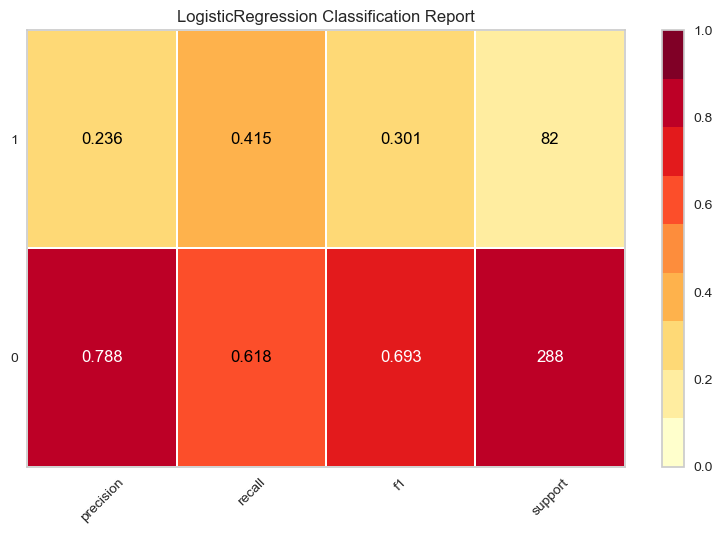

In [362]:
plot_model(model_2_lr,plot='class_report')


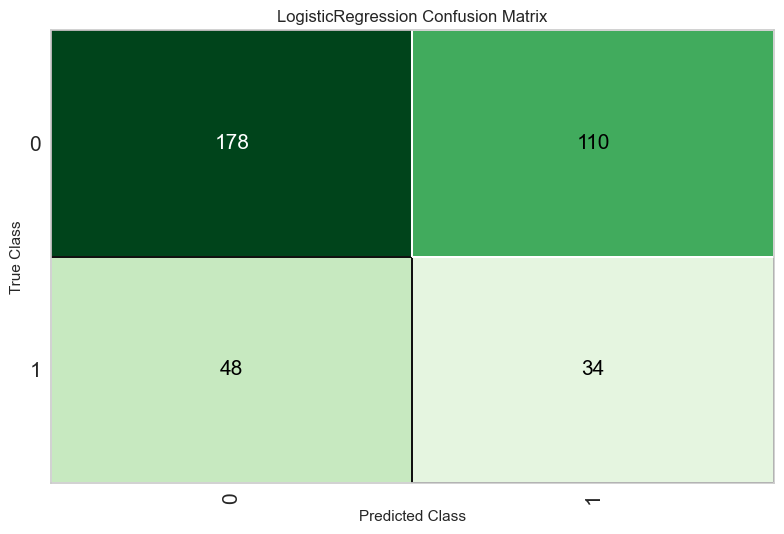

In [363]:
plot_model(model_2_lr,plot='confusion_matrix')


## Validating PyCaret Results with Regular LR Model




In [367]:
df_model_2_copy=df_model_2.copy()


In [368]:
df_model_2_copy.replace([np.inf, -np.inf, np.isfinite], np.nan, inplace=True)
df_model_2_copy = df_model_2_copy.dropna()


In [369]:
# Separate the Y variabless
Y = df_model_2_copy["y"]

# Separate the X variable, the features
# YOUR CODE HERE!
X = df_model_2_copy.drop(columns="y")



In [370]:
# Import the train_test_learn module
from sklearn.model_selection import train_test_split

# Split the data using train_test_split
# Assign a random_state of 1 to the function
# YOUR CODE HERE!
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    random_state=1, 
                                                    stratify=Y,
                                                   test_size=0.30)



In [371]:
# Import RandomOverSampler from imblearn
from imblearn.over_sampling import RandomOverSampler

# Instantiate the RandomOverSampler instance
random_oversampler = RandomOverSampler(random_state=1)

# Fit the data to the model
X_resampled, y_resampled = random_oversampler.fit_resample(X_train, Y_train)


In [372]:
y_resampled.value_counts()


1    520
0    520
Name: y, dtype: int64

In [373]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
# YOUR CODE HERE!
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier

# Fit the model using training data
# YOUR CODE HERE!
classifier.fit(X_resampled, y_resampled)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [374]:
print(f"Training Data Score: {classifier.score(X_resampled, y_resampled)}")
print(f"Testing Data Score: {classifier.score(X_test, Y_test)}")



Training Data Score: 0.5557692307692308
Testing Data Score: 0.5733333333333334


In [375]:
predictions = classifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": Y_test})



,Prediction,Actual
Date,,
2016-02-16,1,1
2018-09-18,0,0
2017-12-19,1,0
2018-05-25,0,1
2017-02-07,0,1
...,...,...
2018-05-24,1,0
2016-03-04,1,0
2014-06-09,1,0


In [376]:
from sklearn.metrics import accuracy_score

# YOUR CODE HERE!
accuracy_score(Y_test, predictions)


0.5733333333333334

In [377]:
from sklearn.metrics import confusion_matrix

# Create and save the confustion matrix for the training data
test_matrix = confusion_matrix(Y_test, predictions)

# Print the confusion matrix for the training data
print(test_matrix)


[[141  82]
 [ 46  31]]


In [378]:
from imblearn.metrics import classification_report_imbalanced


In [379]:
# Print the classification report for the model
# YOUR CODE HERE!
print(classification_report_imbalanced(Y_test, predictions))

# Print the training classification report
#print(Test_report)



                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.63      0.40      0.69      0.50      0.26       223
          1       0.27      0.40      0.63      0.33      0.50      0.25        77

avg / total       0.63      0.57      0.46      0.60      0.50      0.26       300



#  Validating Model Against unseen data
###  Using similar correlation and shift patterns Attempting to validate model
### Back Testing Accuracy 




In [380]:
df_model_3_backtest = dfAllStocks_Yahoo.loc['2018-10-02':'2019-12-31':1]
display(df_model_3_backtest)


,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL
Date,,,,,,,,,,
2018-10-02,106.290001,75.489998,60.355000,64.529999,102.910004,77.519997,30.020000,19.549999,20.930000,67.389999
2018-10-03,106.790001,75.470001,60.514999,64.470001,103.110001,77.500000,30.030001,19.580000,20.820000,65.919998
2018-10-04,106.639999,75.080002,60.459999,64.000000,103.379997,77.220001,29.950001,19.520000,20.799999,64.919998
2018-10-05,105.589996,75.269997,60.255001,63.740002,102.889999,77.029999,29.860001,19.440001,20.740000,64.709999
2018-10-09,105.580002,74.489998,60.020000,63.410000,102.309998,76.510002,29.750000,19.400000,20.750000,65.070000
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,101.250000,73.470001,55.160000,72.790001,103.519997,73.540001,29.549999,18.629999,22.219999,68.720001
2019-12-24,101.120003,73.419998,54.360001,72.940002,103.430000,73.550003,29.540001,18.600000,22.230000,68.550003
2019-12-27,101.010002,73.519997,54.145000,72.150002,103.470001,73.389999,29.340000,18.500000,22.240000,69.180000


In [381]:
df_model_3=pd.DataFrame()
df_model_3['y']= df_model_3_backtest['BNS.TO'].pct_change(7)
df_model_3['CM_30']= df_model_3_backtest['CM.TO'].shift(30).pct_change(26)
df_model_3['CM_30']= df_model_3_backtest['CM.TO'].shift(30).pct_change(5)
df_model_3['NA_27']=df_model_3_backtest['NA.TO'].shift(27).pct_change(12)
df_model_3['TD_41']=df_model_3_backtest['TD.TO'].shift(41).pct_change(39)
df_model_3['BMO_32']=df_model_3_backtest['BMO.TO'].shift(35).pct_change(5)
df_model_3['ZWB_28']=df_model_3_backtest['ZWB.TO'].shift(37).pct_change(15)
df_model_3['ZEB_30']=df_model_3_backtest['ZEB.TO'].shift(30).pct_change(16)
df_model_3['ZEB_25']=df_model_3_backtest['ZEB.TO'].shift(25).pct_change(21)
df_model_3['RY_37']=df_model_3_backtest['RY.TO'].shift(37).pct_change(15)
df_model_3['CL_29']=df_model_3_backtest['CL'].shift(29).pct_change(23)
df_model_3['CL_38']=df_model_3_backtest['CL'].shift(38).pct_change(6)
df_model_3['CL_31']=df_model_3_backtest['CL'].shift(31).pct_change(21)
df_model_3['CL_35']=df_model_3_backtest['CL'].shift(35).pct_change(17)



In [382]:
df_model_3.replace([np.inf, -np.inf, np.isfinite], np.nan, inplace=True)
df_model_3 = df_model_3.dropna()


In [383]:
df_model_3


,y,CM_30,NA_27,TD_41,BMO_32,ZWB_28,ZEB_30,ZEB_25,RY_37,CL_29,CL_38,CL_31,CL_35
Date,,,,,,,,,,,,,
2019-01-31,0.013550,-0.002512,-0.053465,-0.050568,-0.066928,-0.010405,-0.020690,-0.067151,0.014476,0.025591,0.032049,0.067156,0.022168
2019-02-01,0.006133,-0.011707,-0.063752,-0.051871,-0.070312,-0.029396,-0.043712,-0.086349,-0.000313,0.009699,0.005419,0.053508,0.027158
2019-02-04,0.010069,-0.003505,-0.077589,-0.047397,-0.078889,-0.033769,-0.039568,-0.065827,-0.007765,-0.009445,-0.000158,0.007203,0.033296
2019-02-05,0.013185,-0.021033,-0.075513,-0.051538,-0.043597,-0.042368,-0.052688,-0.063799,-0.016310,-0.022756,-0.001910,0.000961,0.046154
2019-02-06,0.011250,-0.035297,-0.056649,-0.061038,-0.040788,-0.045158,-0.065023,-0.063951,-0.021076,-0.052657,0.007931,-0.021505,0.035262
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,-0.016597,0.017973,0.024516,0.045868,-0.001733,0.028587,0.028961,0.031687,0.019334,-0.058574,-0.005564,-0.053905,-0.054754
2019-12-24,-0.005419,0.008897,0.026987,0.045777,0.002853,0.018549,0.025842,0.030262,0.007110,-0.056492,0.022666,-0.056633,-0.073906
2019-12-27,-0.007157,0.002450,0.025611,0.040859,0.009360,0.020697,0.022704,0.027787,0.008415,-0.054967,0.015694,-0.059771,-0.067967


In [384]:
df_model_3['y']=np.where(df_model_3['y']>=0,1,0)


In [385]:
Y_backtest = df_model_3["y"]

# Separate the X variable, the features
# YOUR CODE HERE!
X_backtest = df_model_3.drop(columns="y")


In [386]:
df_model_3['y'].value_counts()


0    114
1    113
Name: y, dtype: int64

In [387]:
predictions_1 = classifier.predict(X_backtest)
bactest_predict=pd.DataFrame({"Prediction": predictions_1, "Actual": Y_backtest})


In [388]:
bactest_predict


,Prediction,Actual
Date,,
2019-01-31,0,1
2019-02-01,0,1
2019-02-04,0,1
2019-02-05,0,1
2019-02-06,0,1
...,...,...
2019-12-23,0,0
2019-12-24,0,0
2019-12-27,0,0


In [389]:
bactest_predict['Prediction'].value_counts()




0    227
Name: Prediction, dtype: int64

In [390]:
print(f"Testing Data Score: {classifier.score(X_backtest, Y_backtest)}")


Testing Data Score: 0.5022026431718062


In [ ]:
# Create and save the confustion matrix for the training data
test_matrix_1 = confusion_matrix(Y_backtest, predictions_1)

# Print the confusion matrix for the training data
print(test_matrix_1)


In [ ]:
from sklearn.metrics import classification_report


In [ ]:

print(classification_report (Y_backtest, predictions_1))
